# Initialization

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam, Nadam, AdamW
from tensorflow.keras.optimizers import Optimizer
from tensorflow.keras.models import save_model
import time
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi

Sat May 10 14:23:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import pickle

def save_all_results(name, history, model, training_time, test_accuracy, save_dir='/content/drive/MyDrive/mv_results'):
    os.makedirs(save_dir, exist_ok=True)

    with open(os.path.join(save_dir, f'{name}_history.json'), 'w') as f:
        json.dump(history.history, f)

    model.save(os.path.join(save_dir, f'{name}_model.h5'))

    summary = {
        'training_time': training_time,
        'test_accuracy': test_accuracy
    }
    with open(os.path.join(save_dir, f'{name}_summary.json'), 'w') as f:
        json.dump(summary, f)

# Data Preprocessing

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)  # One-hot encoding

# Split training data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Resize images to (96, 96)
def preprocess(image, label):
    image = tf.image.resize(image, (96, 96))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(preprocess).shuffle(1000).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).map(preprocess).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(preprocess).batch(batch_size)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


# Build Model

In [ ]:
def train(optimizer, epochs):

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=1)
    end_time = time.time()
    training_time = end_time - start_time

    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)

    return history, model, training_time, test_accuracy

# Build Optimizer

In [ ]:
class Lion(Optimizer):
    def __init__(
        self, learning_rate=0.001, beta_1=0.9, beta_2=0.99, weight_decay=1e-4, name="lion", **kwargs):
        super().__init__(learning_rate=learning_rate, name=name, **kwargs)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.weight_decay = weight_decay

    def build(self, var_list):
        if self.built:
            return
        super().build(var_list)

        self._momentums = []
        for var in var_list:
            self._momentums.append(
                self.add_variable_from_reference(
                    reference_variable=var, name="momentum"
                )
            )

    def update_step(self, gradient, variable, learning_rate):

        lr = tf.cast(learning_rate, variable.dtype)
        gradient = tf.cast(gradient, variable.dtype)

        beta_1 = tf.cast(self.beta_1, variable.dtype)
        beta_2 = tf.cast(self.beta_2, variable.dtype)
        weight_decay = tf.cast(self.weight_decay, variable.dtype)

        m = self._momentums[self._get_variable_index(variable)]

        update = tf.sign(beta_1 * m + (1.0 - beta_1) * gradient)

        new_m = beta_2 * m + (1.0 - beta_2) * gradient
        self.assign(m, new_m)

        final_update = lr * (weight_decay * variable + update)
        self.assign_sub(variable, final_update)


# Train Model

In [ ]:
optimizers = {
    'SGD': SGD(learning_rate=0.001, momentum=0.9),
    'SGD_Nesterov': SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    'Adam': Adam(learning_rate=0.001),
    'Adam_Amsgrad': Adam(learning_rate=0.001, amsgrad=True),
    'AdamW': AdamW(learning_rate=0.001, weight_decay=1e-4),
    'Nadam': Nadam(learning_rate=0.001),
    'Lion': Lion(learning_rate=1e-4)
}

histories = {}
training_times = {}
models = {}
test_accuracies = {}

for name, optimizer in optimizers.items():
    print(f"Training with {name} optimizer...")

    histories[name], models[name], training_times[name], test_accuracies[name] = train_model_with_optimizer(optimizer, 20)

    save_all_results(name, histories[name], models[name], training_times[name], test_accuracies[name])

Training with SGD optimizer...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.6375 - loss: 1.1791 - val_accuracy: 0.8428 - val_loss: 0.4548
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.7909 - loss: 0.6265 - val_accuracy: 0.8498 - val_loss: 0.4267
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.8055 - loss: 0.5751 - val_accuracy: 0.8562 - val_loss: 0.4238
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8104 - loss: 0.5611 - val_accuracy: 0.8546 - val_loss: 0.4265
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8127 - loss: 0.5534 - val_accuracy: 0.8536 - val_loss: 0.4195
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8199 - loss: 0.5364 - val_accuracy: 0.8560 - val_loss: 0.4136
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8185 - loss: 0.5336 - val_accuracy: 0.8578 - val_loss: 0.4

Training with SGD_Nesterov optimizer...
Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.6435 - loss: 1.1499 - val_accuracy: 0.8436 - val_loss: 0.4569
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.7908 - loss: 0.6209 - val_accuracy: 0.8452 - val_loss: 0.4515
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8057 - loss: 0.5735 - val_accuracy: 0.8456 - val_loss: 0.4362
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8097 - loss: 0.5573 - val_accuracy: 0.8478 - val_loss: 0.4264
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8136 - loss: 0.5552 - val_accuracy: 0.8538 - val_loss: 0.4177
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8176 - loss: 0.5323 - val_accuracy: 0.8548 - val_loss: 0.4165
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8203 - loss: 0.5250 - val_accuracy: 0.8530 - val_loss: 0.4234
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━

Training with Adam optimizer...
Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.6670 - loss: 1.0799 - val_accuracy: 0.8374 - val_loss: 0.4656
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8068 - loss: 0.5833 - val_accuracy: 0.8488 - val_loss: 0.4386
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.8117 - loss: 0.5706 - val_accuracy: 0.8430 - val_loss: 0.4460
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8106 - loss: 0.5772 - val_accuracy: 0.8538 - val_loss: 0.4327
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.8162 - loss: 0.5690 - val_accuracy: 0.8518 - val_loss: 0.4347
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8151 - loss: 0.5662 - val_accuracy: 0.8472 - val_loss: 0.4387
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8150 - loss: 0.5606 - val_accuracy: 0.8556 - val_loss: 0.4237
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20

Training with Adam_Amsgrad optimizer...
Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.6615 - loss: 1.0934 - val_accuracy: 0.8494 - val_loss: 0.4364
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.8051 - loss: 0.5849 - val_accuracy: 0.8536 - val_loss: 0.4308
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.8116 - loss: 0.5659 - val_accuracy: 0.8470 - val_loss: 0.4418
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8168 - loss: 0.5551 - val_accuracy: 0.8544 - val_loss: 0.4230
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8148 - loss: 0.5553 - val_accuracy: 0.8576 - val_loss: 0.4237
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8192 - loss: 0.5491 - val_accuracy: 0.8540 - val_loss: 0.4210
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8168 - loss: 0.5459 - val_accuracy: 0.8548 - val_loss: 0.4213
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━

Training with AdamW optimizer...
Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.6686 - loss: 1.0761 - val_accuracy: 0.8436 - val_loss: 0.4468
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.8054 - loss: 0.5823 - val_accuracy: 0.8510 - val_loss: 0.4292
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8112 - loss: 0.5739 - val_accuracy: 0.8458 - val_loss: 0.4578
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8150 - loss: 0.5683 - val_accuracy: 0.8536 - val_loss: 0.4388
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8159 - loss: 0.5679 - val_accuracy: 0.8572 - val_loss: 0.4137
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.8154 - loss: 0.5670 - val_accuracy: 0.8556 - val_loss: 0.4239
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.8132 - loss: 0.5694 - val_accuracy: 0.8478 - val_loss: 0.4519
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1

Training with Nadam optimizer...
Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - accuracy: 0.6570 - loss: 1.1300 - val_accuracy: 0.8504 - val_loss: 0.4305
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8041 - loss: 0.5876 - val_accuracy: 0.8582 - val_loss: 0.4217
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.8151 - loss: 0.5577 - val_accuracy: 0.8486 - val_loss: 0.4397
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8114 - loss: 0.5657 - val_accuracy: 0.8532 - val_loss: 0.4207
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8139 - loss: 0.5639 - val_accuracy: 0.8510 - val_loss: 0.4400
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.8159 - loss: 0.5540 - val_accuracy: 0.8542 - val_loss: 0.4246
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8181 - loss: 0.5634 - val_accuracy: 0.8510 - val_loss: 0.4385
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2

Training with Lion optimizer...
Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.5449 - loss: 1.5938 - val_accuracy: 0.8526 - val_loss: 0.4318
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.8080 - loss: 0.5781 - val_accuracy: 0.8524 - val_loss: 0.4186
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8165 - loss: 0.5561 - val_accuracy: 0.8592 - val_loss: 0.4178
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8163 - loss: 0.5535 - val_accuracy: 0.8570 - val_loss: 0.4175
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8180 - loss: 0.5533 - val_accuracy: 0.8598 - val_loss: 0.4198
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8175 - loss: 0.5571 - val_accuracy: 0.8558 - val_loss: 0.4274
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8192 - loss: 0.5440 - val_accuracy: 0.8552 - val_loss: 0.4228
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17

AttributeError: 'Lion' object has no attribute '_serialize_hyperparameter'

In [ ]:
optimizers = {
    'Lion': Lion(learning_rate=1e-4)
}

for name, optimizer in optimizers.items():
    print(f"Training with {name} optimizer...")

    histories[name], models[name], training_times[name], test_accuracies[name] = train_model_with_optimizer(optimizer, 20)

    save_all_results(name, histories[name], models[name], training_times[name], test_accuracies[name])

Training with Lion optimizer...
Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.5525 - loss: 1.5438 - val_accuracy: 0.8536 - val_loss: 0.4285
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8091 - loss: 0.5888 - val_accuracy: 0.8560 - val_loss: 0.4146
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8151 - loss: 0.5636 - val_accuracy: 0.8564 - val_loss: 0.4150
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.8171 - loss: 0.5546 - val_accuracy: 0.8548 - val_loss: 0.4209
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8172 - loss: 0.5532 - val_accuracy: 0.8576 - val_loss: 0.4189
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.8199 - loss: 0.5546 - val_accuracy: 0.8568 - val_loss: 0.4208
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8189 - loss: 0.5571 - val_accuracy: 0.8584 - val_loss: 0.4169
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 23

# Downlaod Data and Plot Figure

In [ ]:
import json

optim_names = ['SGD', 'SGD_Nesterov', 'Adam', 'Adam_Amsgrad', 'AdamW', 'Nadam', 'Lion']

histories = {}
test_accuracies = {}
training_times = {}

for name in optim_names:

    with open(f"/content/drive/MyDrive/mv_results/{name}_history.json", "r") as f:
        histories[name] = json.load(f)

    with open(f"/content/drive/MyDrive/mv_results/{name}_summary.json", "r") as f:
        summary = json.load(f)
        test_accuracies[name] = summary["test_accuracy"]
        training_times[name] = summary["training_time"]

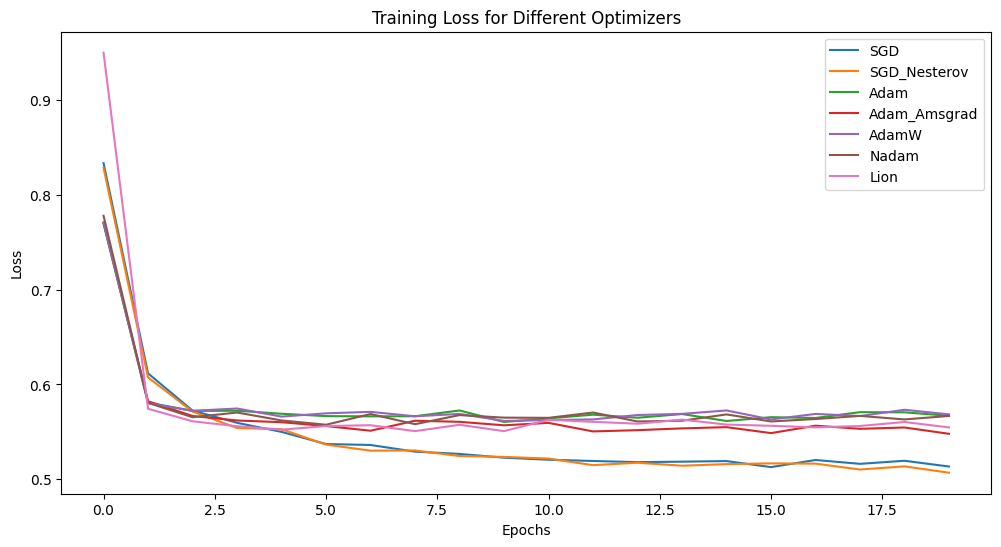

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

for name, history in histories.items():
    plt.plot(history['loss'], label=f"{name}")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss for Different Optimizers')
plt.show()

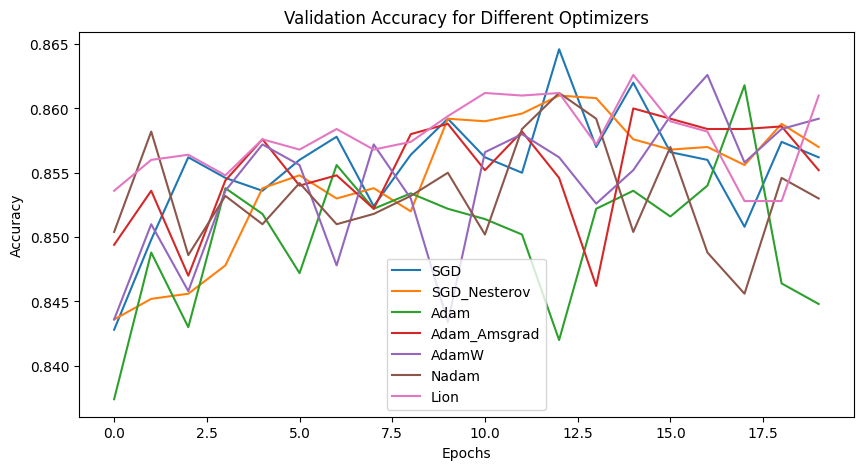

In [ ]:
plt.figure(figsize=(10, 5))
for name, history in histories.items():
    plt.plot(history['val_accuracy'], label=f"{name}")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy for Different Optimizers')
plt.show()

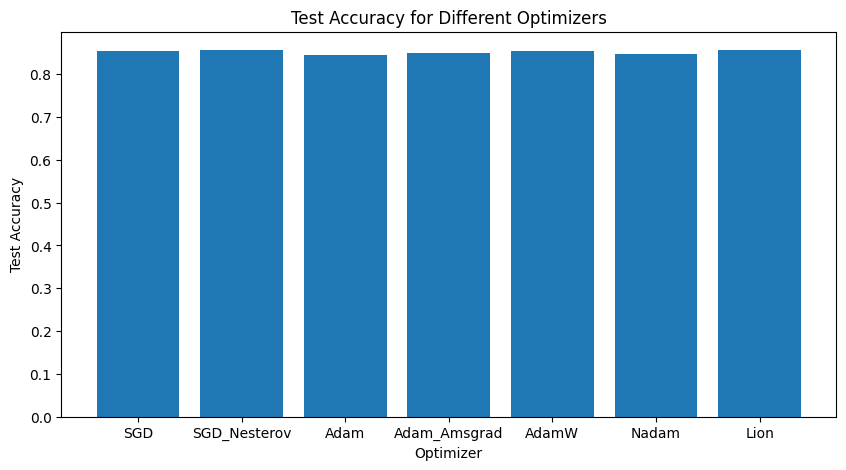

In [ ]:
plt.figure(figsize=(10, 5))

plt.bar(test_accuracies.keys(), test_accuracies.values())
plt.xlabel('Optimizer')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy for Different Optimizers')
plt.show()

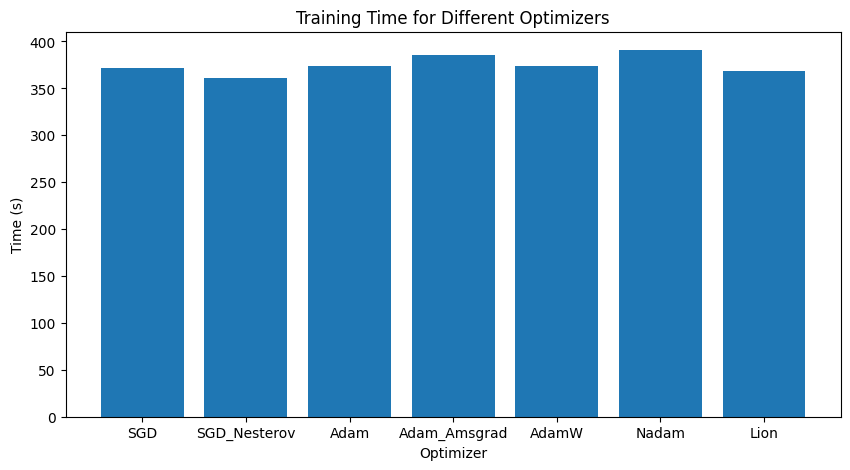

In [ ]:
plt.figure(figsize=(10, 5))

plt.bar(training_times.keys(), training_times.values())
plt.xlabel('Optimizer')
plt.ylabel('Time (s)')
plt.title('Training Time for Different Optimizers')
plt.show()

In [ ]:
print(test_accuracies)
print(training_times)

{'SGD': 0.8551999926567078, 'SGD_Nesterov': 0.8568000197410583, 'Adam': 0.8446999788284302, 'Adam_Amsgrad': 0.8497999906539917, 'AdamW': 0.8531000018119812, 'Nadam': 0.8481000065803528, 'Lion': 0.8560000061988831}
{'SGD': 371.8540201187134, 'SGD_Nesterov': 360.54971742630005, 'Adam': 373.9125416278839, 'Adam_Amsgrad': 385.90314054489136, 'AdamW': 374.18882060050964, 'Nadam': 390.9120111465454, 'Lion': 367.96949529647827}
